# An introduction to the Seats-Votes Curve

*Levi John Wolf<br>
University of Bristol<br>
levi.john.wolf@gmail.com<br>
(Supported by NSF #1657689)*

# The History of the Seats-Votes Curve

The "seats votes curve," a theoretical model describing how many seats a party wins in the legislature as a function of their popular vote percentage, is a long-lived concept in Political Science. Early work studying the British electoral system focused on the ["Cube Rule,"](https://en.wikipedia.org/wiki/Cube_rule), a theory describing how winners tend to be *overrepresented* in legislatures in two-party, first-past-the-post electoral systems like that found in the US, New Zealand, or the UK. While originally formulated in the early 20th century, empirical study of the law continued in earnest until around the 1970s. There, studies by Kendall (1950), Taagepara (1973), and Tufte (1973) discuss the relationship in terms of a *long-run* historical relationship. For them, the seats-votes curve is an *empirical description of the relationship between the vote share a party won and the percentage of the legislature that the party ended up winning.* Thus, much of the early work on *structural analysis* of electoral systems focused on the detection of empirical regularities. 

Later work after Browning (1987) or Gelman (1994) moved to a much stronger inferential framework in order to try to estimate this relationship *within individual elections*. Much of the recent academic work on partisan gerrymandering comes in this mode of analysis. For example, nearly all of the entries in the [**Common Cause Gerrymandering Writing Competition**](https://www.commoncause.org/partisan-gerrymandering-writing-competition/) were in this mode of analysis, and many of the political models used by "ensemble" analyses following Chen & Rodden (2013) follow this approach. 

In hopes of providing some groundwork in electoral sciences, I'll cover a little bit about the historical method of analysis before we move to the within-election analysis that's more common today. I'll talk about the logic of the model, possible pitfalls with its interpretation and representation of elections. This work is built in Python, on top of the `seatsvotes` library, a new library for working with Electoral Data, like `pscl` in R. 

First, though, let's pull in some required packages for our analysis. The `import` statement in Python is kind of like the `library()` statement in `R`, except that in Python we always refer to the package explicitly when we use a function from that package (like you might if you used `dplyr::mutate()` instead of just `mutate()`). 

In [1]:
import pandas
import numpy
import seaborn
import seatsvotes
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

/home/lw17329/anaconda/envs/ana/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lw17329/anaconda/envs/ana/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


The `seatsvotes` package is a new package developed as part of NSF 1657689, and wraps up a couple of previous methods for modelling seats-votes curves (like Gelman & King (1994), Linzer (2013), an adaptation of McGann et al. (2014)) and a few new methods. It also ships with it much of the example data that is used in common explorations of electoral bias.

So, to start our exploration, let's first load in the example dataset provided for historical elections to the US Congress from 1896 to 2010. This is a subset of the data available from the [**Spatiotemporal Database of Congressional Elections**](https://www.nature.com/articles/sdata2017108). Since we're not working with the spatial data, we'll primarily be using the results that bridge the original ICSPR 6311 and later products from the Consitituency Level Electoral Archive. 

In [2]:
house = seatsvotes.data.congress()

In [3]:
house.head()

,year,idx,state,dist,inc,vote_share,turnout,south
0,1896,1,1,1,NaN,0.282184,38482.0,0
1,1896,2,1,2,NaN,0.383052,58261.0,0
2,1896,3,1,3,NaN,0.334220,22934.0,0
3,1896,4,1,4,NaN,0.338997,46381.0,0
4,1896,5,2,1,NaN,0.312600,28119.0,0


By convention, we usually model Democrats as the "Reference party," but this can be flipped and the analyses simply flip as well.

# The finnicky nature of averages

Early on, work in this literature was fairly consistently concerned with the distinction between *party vote share* and *average district vote share*. Subtly, this distinction arises because the average of each districts' vote shares *is not* equal to the percent of all votes the party receives. Basically, if we let 
- $v_i$ be the number of votes cast for Democrats in district $i$
- $n_i$ be the total number of votes cast in district $i$
- $k$ be the number of districts in the electoral system,

this concern arises because the "total" popular vote percentage for a party is not equal to its average vote share among districts; since districts have different turnouts, the two aren't equal in general:
$$ \frac{\sum_{i}^k v_i}{\sum_{i}^k n_i} \neq \frac{1}{k} \sum_i^k \frac{v_i}{n_i}$$

Or really simply, say we have two districts, one with 4 voters and the other with 6 voters. Let's say the smaller district has 3 Democrat voters and the larger district has 3 as well. Then, we can see this ineqality in action: 

In [4]:
(3+3)/(4 + 6) # The popular vote for Dems

0.6

In [5]:
((3/4) + (3/6))/2 # The average district vote for Dems

0.625

Practically speaking, this does not pose serious challenges to an analysis, so long as we recognize that the two are distinct conceptually and have different practical implications. In general, again, modern scholarship tends to focus on the mean district vote share because it's simpler to model, and tends to have more actionable impacts for practical models of elections. However, as Johnston (1983) discusses, this distinction can have a big impact when discussing the power of changes in vote share in specific districts. 

I'll illustrate the difference systematically below, but we'll need to keep this in mind later when discussing how seats-votes relationships may show *asymmetry* or *bias* for one party over another. 

In [6]:
house['dem_votes'] = house.vote_share * house.turnout

Since we're working in Pandas, we can build up each years' average district voteshare *as well as* the the party voteshare in each year. I'll do this to show the discrepancy that occurs in the relationship (since it's often structurally-relevant).

First we group:

In [7]:
grouper = house.groupby('year')

Then, get the total Dem votes in each year divided by the total turnout that year to get the *party voteshare*, or the popular vote for Dems:

In [8]:
party_voteshare = grouper.dem_votes.sum() / grouper.turnout.sum()

Then, we can use the `.mean()` method directly to get the mean of district voteshares:

In [9]:
party_average_voteshare = grouper.vote_share.mean()

Finally, while it can sometimes be flawed in multi-party elections, we'll rely on the fact that this data is *two party vote* data, not raw elections data. This means that we're only considering votes cast for one of the two main parties; all of the rest of the votes are discarded in this analysis. With this in mind, we can find whether or not the Democrat candidate won in the district by looking at whether or not the district's vote share for Democrats is more than 50%. In two-party vote share data, this means that the Democratic vote share is larger than the Republican vote share, regardless of if *neither of them* win an outright majority. 

In [10]:
party_seatshare = grouper.apply(lambda x: (x.vote_share > .5).mean())

Now, we have the party's popular vote (or party voteshare) in each election to Congress since 1896, we have the average district vote too, and we have the fraction of the congress Dems won that year.

Then, we can see the way the average district vote (or the popular voteshare) are related to the fraction of Congress Dems win by making a scatterplot of all the years together:

Text(0,0.5,'% Seats won by Dems')

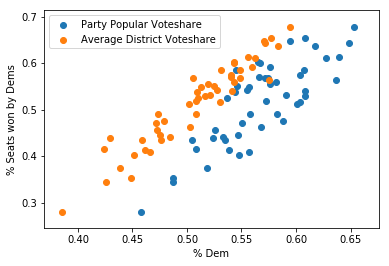

In [11]:
plt.scatter(party_average_voteshare, party_seatshare, 
            label='Party Popular Voteshare')
plt.scatter(party_voteshare, party_seatshare, 
            label='Average District Voteshare')
plt.legend()
plt.xlabel("% Dem")
plt.ylabel("% Seats won by Dems")

Note that, in general, the average district voteshare is *smaller than* the party popular voteshare. At its most basic, this is because how *Democrat* a district is tends to be correlated with its turnout, especially in the Modern congress, after the 1960s realignment. Namely, if an election is *really low* turnout, it's probably going to be overwhelmingly Democrat:

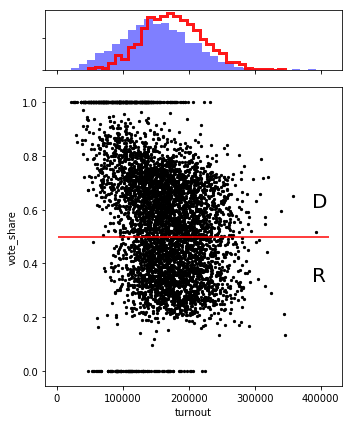

In [12]:
f,ax = plt.subplots(2,1,figsize=(5,6), gridspec_kw=dict(height_ratios=(1,5)), sharex=True)
house.query('year > 1968').plot.scatter('turnout', 'vote_share', color='k', marker='.', ax=ax[1])
ax[1].hlines(.5, *ax[1].get_xlim(), color='r')
ax[1].annotate(xy=(.9,.6), s='D', xycoords=ax[1].transAxes, fontsize=20)
ax[1].annotate(xy=(.9,.35), s='R', xycoords=ax[1].transAxes, fontsize=20)

ax[0].hist(house.query('year > 1968').query('vote_share > .5').turnout.values, 
            alpha=.5, bins=30, color='b', density=True)
ax[0].hist(house.query('year > 1968').query('vote_share < .5').turnout.values, 
           alpha=.9, bins=30, color='r', histtype='step', linewidth=3, density=True)
ax[0].set_yticklabels([])
plt.tight_layout()
plt.show()

This discrepancy itself; that elections with Democrats tend to lose large-turnout elections and win small-turnout ones is one of the main motivations behind many recent estimators of structural bias in electoral systems. As we'll see later, this can have some pretty significant structural impacts on elections, and mainly arises from the fact that districts tend to have *even population* (when they're drawn at least), but can have *vastly different* sizes of electorates.

# The classic seats-votes model: The Cube Rule

But, going onto the Cube Rule & The empirical seats-votes curve, the cube rule suggests that:

> if party $i$ gets $p_i$ percent of the popular vote and party $j$ gets $p_j$ percent of the vote, the ratio between the two party's *seat shares* is given by the cube of the ratio of their voteshares:

$$ \frac{s_i}{s_j} = \left(\frac{p_i}{p_j}\right)^3$$

Fortunately, in a two-party first-past-the-post system, we can assume that $s_i = 1 - s_j$ and $p_i = 1 - p_j$. This means that:

$$ \frac{s_i}{1 - s_i} = \left(\frac{p_i}{1 - p_i}\right)^3$$

And, given a little bit of mathematics, we can state this in terms of *log odds ratios*:

$$ \log\left( \frac{s_i}{1 - s_i}\right) = 3\log\left(\frac{p_i}{1 - p_i}\right) $$

Now, the *Cube Rule* is not a natural law of elections; there's no real intrinsic reason why this should hold in general. But, back in the early 20th century, it held with a remarkable regularity in contexts that were studied. 

Later analyses focusing on the *Cube Rule* focused on an inferential framework. This *historical* or *descriptive* model of the relationship between seats and votes used the *cube rule* as the starting point, e.g. following Kendall (1950), but instead tended to examine the relationship between seats and votes using a regression model. This means that the "cube" in the *Cube Rule* now became a quantity estimated from the data. Further, for Tufte (1973), this also allowed a notion of the *intrinsic* bias of an electoral system to be assessed. Namely, we re-express the cube rule statement from above like a regression model relating the log-odds of seat shares to the log-odds of vote shares for Democrats:

$$ \log\left( \frac{s_i}{1 - s_i}\right) = \alpha + \beta\log\left(\frac{p_i}{1 - p_i}\right) + \epsilon$$

This model is a standard linear regression on variables that have been converted to their log odds ratios. The "predictor" variable is the log odds ratio of the Democrat popular vote share and the "response" variable is the log odds ratio of the percent of the legislature Democrats win. 

Just thinking conceptually for a second, the $\beta$ parameter here would measure how quickly Democrat seat share changes as a function of Democrat vote share. In general, this "speed of change" in the seats won per change in vote has now come to be called the _**responsiveness**_ of the electoral system, regardless of how it is estimated. Likewise, the $\alpha$ parameter would measure the *deflection* from a straightforward linear relationship. We can see this visually as follows:

Text(0.5,0,'Theoretical Votes (% D)')

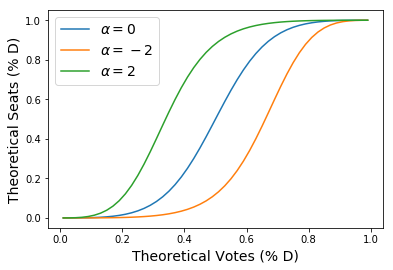

In [13]:
vote_space = numpy.linspace(.01,.99)
logodds = lambda x: numpy.log(x/(1-x))
logit = lambda x: (numpy.exp(x))/(1 + numpy.exp(x))

for a in (0,-2,2):
    plt.plot(vote_space, logit(a + 3*logodds(vote_space)), label='$\\alpha={}$'.format(a))
plt.legend(fontsize=14)
plt.ylabel("Theoretical Seats (% D)", fontsize=14)
plt.xlabel("Theoretical Votes (% D)", fontsize=14)

Now, we see that the three curves are shifted. In all cases, the _**responsiveness**_ is $3$ for the curves shown. Since the transformation is *nonlinear*, this $3$ refers to the slope of the *log odds ratio*, not the slope of the seats & votes directly, but (for example) in the flat area near $.5$, we can see that the % of seats Democrats win tends to rise *faster* than the % of votes Dems win. This means that a $\beta$ of 3 is *hyperproportional*, meaning that *more* seats are awarded than a proportional system, where a change in party voteshare results in the same change in party seatshare. 


Fundamentally, we can assess the shift with respect to the blue curve, when $\alpha=0$. When $\alpha=0$, the curve for Democrats would be the exact same as the curve for Republicans. Second, we see that, in the green curve when $\alpha=2$, Democrats win *more seats* for the same amount of popular vote than when $\alpha=0$. When $\alpha=-2$, the curve in yellow shows that Democrats win *fewer seats* for the same amount of popular vote. Notably, if we were to *flip* the party that is modelled, $\beta$ stays the same but $\alpha$ flips in sight. Thus, when $\alpha$ is positive, it suggests that *Democrats win more seats at a given share of votes than Republicans*, and when $\alpha$ is negative, *Dems win fewer seats than Republicans at the same share of popular vote*. Therefore, $\alpha$ is often called the _**bias**_ parameter of these kinds of models.

### Back to the Cube Rule

Moving back to the the *Cube Rule*, it would suggest that $\beta = 3$ and $\alpha = 0$. Tufte (1973) ran this analysis for a collection of elections and found that $\beta$ was closer to $2$ than $3$ for the elections he considered. He also observed that many of the systems he analyzed were biased in some direction. 

To do this ourselves, let's first build the *odds* variables for both party seat share and party vote share:

In [14]:
odds_voteshare = party_voteshare / (1-party_voteshare)
odds_seatshare = party_seatshare / (1-party_seatshare)

Then, we can run the regression we see above: 

In [15]:
svcurve_data = pandas.DataFrame(dict(seats = numpy.log(odds_seatshare), 
                                     votes = numpy.log(odds_voteshare)))

log_odds_model = sm.formula.ols("seats ~ votes", data=svcurve_data).fit()

And get a summary for the regression:

In [16]:
log_odds_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  seats   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     459.0
Date:                Fri, 02 Nov 2018   Prob (F-statistic):           6.77e-26
Time:                        14:12:42   Log-Likelihood:                 38.341
No. Observations:                  49   AIC:                            -72.68
Df Residuals:                      47   BIC:                            -68.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0014      0.016     -0.087      0.931      -0.034       0.032
votes          1.8029      0.084     21.424      0.000       1.634       1.972
==============================================================================
Omnibus:                        0.712   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.701   Jarque-Bera (JB):                0.166
Skew:                          -0.038   Prob(JB):                        0.920
Kurtosis:                       3.275   Cond. No.                         5.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This means that our _**bias**_, $\alpha$ the Intercept, is empirically too small to be meaningful in the data on elections from 1896 to 1992, and that our _**responsiveness**_ is about 2. Empirically, we can plot the fit of this curve as: 

Text(0,0.5,'% Seats won by Dems')

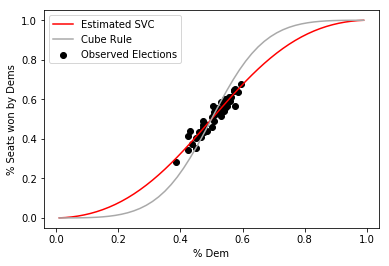

In [17]:
plt.scatter(party_voteshare, party_seatshare, 
            label='Observed Elections', color='k')
seats_votes_curve = logit(log_odds_model.params.Intercept + log_odds_model.params.votes * logodds(vote_space))
plt.plot(vote_space, seats_votes_curve, color='r', label='Estimated SVC')
plt.plot(vote_space, logit(3*logodds(vote_space)), color='darkgrey', label='Cube Rule')
plt.legend()
plt.xlabel("% Dem")
plt.ylabel("% Seats won by Dems")

Or, zooming into the center where all the action is:

Text(0,0.5,'% Seats won by Dems')

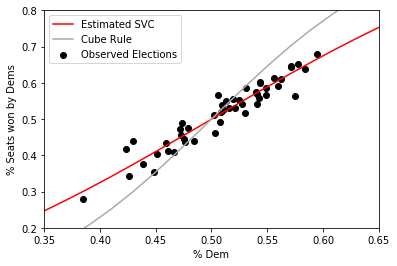

In [18]:
plt.scatter(party_voteshare, party_seatshare, 
            label='Observed Elections', color='k')
seats_votes_curve = logit(log_odds_model.params.Intercept + log_odds_model.params.votes * logodds(vote_space))
plt.plot(vote_space, seats_votes_curve, color='r', label='Estimated SVC')
plt.plot(vote_space, logit(3*logodds(vote_space)), color='darkgrey', label='Cube Rule')
plt.xlim(.35,.65)
plt.ylim(.2, .8)
plt.legend()
plt.xlabel("% Dem")
plt.ylabel("% Seats won by Dems")

We see that ever-so-miniscule bias in the red curve (since it passes slightly above $.5,.5$) and we see its responsiveness is much lower than the estimate suggested by the Cube Rule. 

Further, you can see that the data also *very clearly* fits a simple, straight line relating seat shares and vote shares. However, we typically *don't* do direct linear regression on the seats & votes because the linear model can return invalid predictions (i.e. seat shares beyond $1$ or below $0$). In addition, the interpretation of the _**responsiveness**_ parameter becomes more direct; it relates the "direct" observed change in seat share as a function of party vote share. But, the _**bias**_ parameter is less interpretable, since the linear form is likely to vastly mis-predict the election results in extreme vote shares, like when $p_i=0$. It *can* be estimated and interpreted, but this estimate may not really correspond to anything meaningful because of this extreme counterfactual. 

# Conclusion

Seats-votes models are a longstanding way to discuss electoral systems. These models predict the percent of a legislature won by a party as a function of their popular vote. We can fit the same model in terms of the district average vote share, but (in general) the analyses that use this technique tended to examine the *party popular vote* instead. Thus, many of the models *describing* a historical seats-votes curve do so using historical data recording the percentage of seats a party wins in a legislature, and the party's percentage of the popular vote. 

Seats-Votes  models have varied significantly in their form, shape, and justification since the early 1900s, when electoral geographers in Britain first noticed the *Cube Rule*, an empirical regularity in the seats-votes relationship. For their data, these geographers suggested that the ratio between two parties' seat shares in Parliament was roughly a function of the cube of the ratio of their popular vote shares:

$$ \frac{s_i}{1 - s_i} = \log\left(\frac{p_i}{1 - p_i}\right)^3 $$

Empirically speaking, many analyses have now found that this "rule" tends not to hold in general, though it definitely does hold in the empirical circumstances where the original electoral scientists identified it. In general, quoting Tufte, it may be more accurate to say the rule is the $2.5$-rule. In the data we discuss today, coming from replication materials for Gelman & King (1994), we might say the rule for the US appears to be approximate an $1.8$ rule. 

Indeed, in general, we can *estimate* the relationships between seat shares won by a party and their popular vote using a variety of regression forms. Given the distributional structure of vote shares and seat shares (which are both proportions), a very large variety of methods have been used to try to predict these accurately. However, in this notebook, we discussed Tufte (1973)'s Log Odds Regression, which is a direct re-statement of the *Cube Rule* in a simple to understand regression framework:

$$ \log\left( \frac{s_i}{1-s_i}\right) = \alpha + \beta \log\left(\frac{p_i}{1-p_i}\right)$$

This model has two fundamental components: an $\alpha$ term that models the _**bias**_ of the electoral system. When it is positive, it suggests that that the system favors the reference party of the analysis (here, Democrats). The $\beta$ term models the _**responsiveness**_ of the system; how many seats are won for each change in the popular vote. These are fundamental properies which are used to describe electoral systems *again and again* throughout the ages, and we will return to these concepts later in the series. 